<a href="https://colab.research.google.com/github/JiwooLee0822/transformer/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scaled Dot-Product Attention

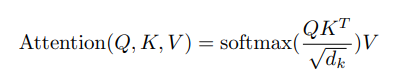


In [4]:
import torch
import math
import torch.nn as nn

In [7]:
class scale_dot_product_attention(nn.Module):
  def __init__(self):
    super(scale_dot_product_attention).__init__()
    self.softmax = nn.Softmax()

  def forward(self, q, k, v, mask = None, e = 1e-12):
    # input is 4 dimension tensor
    batch_size, head, length, d_tensor = k.size

    # dot product Q with K^T -> compute similarity
    k_t = k.view(batch_size, head, d_tensor, length)
    score = (q @ k_t) / math.sqrt(d_tensor) # @연산은 np.matmul과 같은 역할

    # masking (optional)
    if mask is not None:
      score = score.masked_fill(mask == 0, -e)

    score = self.softmax(score) # make [0,1] range
    v = score @ v # multiply with value

    return v, score


## Multi-Head Attention

### 논문에서는 n_head = 8로 지정하였으며, 이에 따라 d_model = 512를 n_head로 나눈 64차원의 q, k, v에 대해서 병렬 attention 수행함.

### 이후, 각 연산 결과를 합치는 concatenate 과정 진행하고, 가중치 행렬 곱함.

In [8]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_head):
    super(MultiHeadAttention, self).__init__()
    self.n_head = n_head
    self.attention = scale_dot_product_attention()
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)
    self.w_concat = nn.Linear(d_model, d_model)

  def split(self, tensor):
    # splits tensor by number of head
    batch_size,length, d_model = tensor.size()
    d_tensor = d_model//self.n_head

    tensor = tensor.view(batch_size, self.n_head, length, d_tensor)

    return tensor

  def concat(self, tensor):
    batch_size, head, length, d_tensor = tensor.size()
    d_model = head*d_tensor

    tensor = tensor.view(batch_size, length, d_model)
    return tensor

  def forward(self, q, k, v, mask = None):
    # dot product with weight metrics
    q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)
    # split tensor by number of heads
    q, k, v = self.split(q), self.split(k), self.split(v)
    # do scale dot product (attention 계산)
    out, attention = self.attention(q, k, v, mask = mask)
    # concat and pass to linear layer
    out = self.concat(out)
    out = self.w_concat(out)

    return out

